###                                  ISOC731 - Projet 

Nous avons un projet à réaliser pour ce module. Celui-ci porte sur les réseaux de graphes. C'est à dire que nous allons générer différents graphes puis les analyser.

###                                  Exercice 1 : 

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random as rd
import numpy as np
from tqdm import tqdm
import pandas as pd
import scipy.stats as st

In [7]:
n = 1000 # nombre de noeuds 

def make_graph(n): # fonction pour initialiser un graphe vide de n noeuds
    G = nx.Graph()
    for i in range(n):
        G.add_node(1)
    return G

def make_edges(G,p): # fonction pour ajouter des liens entre différents noeuds 
    """
    graph G : initial graph
    int p : probability of connexion between two nodes
    """
    for k in range(n):
        for node in list(G.nodes):
            # On vérifie qu'une probabilité uniforme est inférieure ou égale à notre probabilité seuil
            # De plus, on vérifie que les deux noeuds choisis ne sont pas les même
            if(rd.uniform(0.0, 1.0) <=p and node != k):
                G.add_edge(k,node)
    return G

# On initalise notre graphe vide
graph_global = make_graph(n)

100%|██████████| 50/50 [00:10<00:00,  4.60it/s]


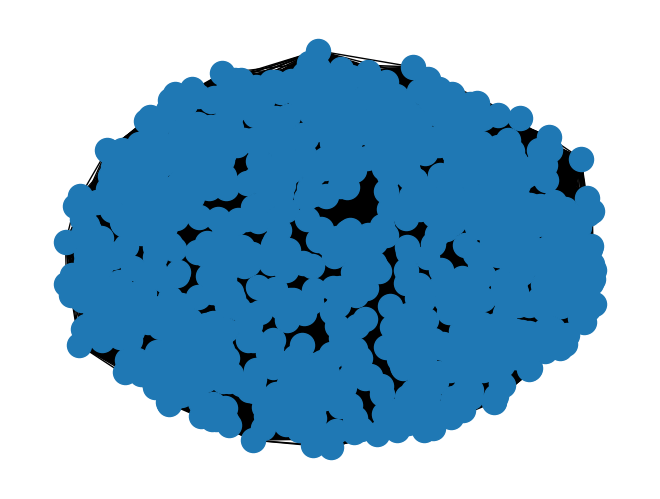

In [8]:
graphs = [] # Liste des différents graphes
probabilities = [] # Liste des probabilités

p = 0.01 # Probabilité minimale

# Nous parcourons pour 50 graphes
for i in tqdm(range(50)):
    # On crée les liens d'un nouveau graphe à partir de la copie du graphe précédemment créé
    graphs.append(make_edges(graph_global.copy(), p))
    probabilities.append(p)
    p += 0.01 # Pas de la probabilité

# Affiche le graphe avec la probabilité la plus haute
nx.draw(graphs[len(graphs)-1])

100%|██████████| 50/50 [00:00<00:00, 243.87it/s]


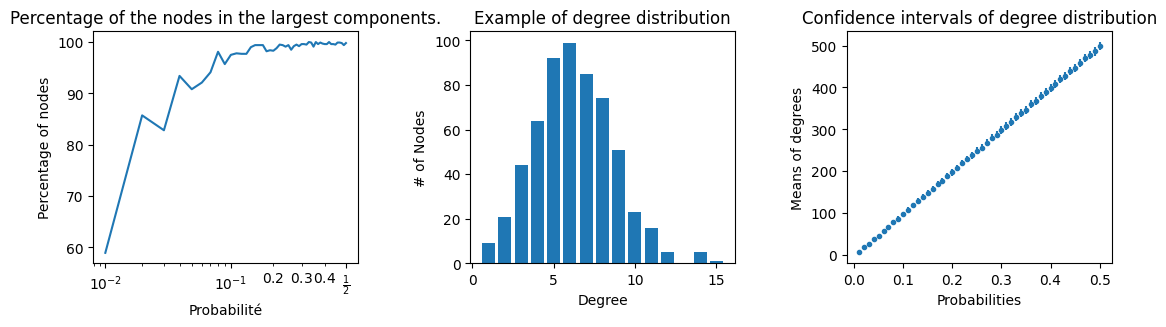

In [9]:
# On initialise nos tableaux
degree_distributions = []
largest_components = []
degrees = []

# On parcourt tous les graphes afin de récupérer leur dégré ainsi que le plus gros cluster
for g in tqdm(graphs):
    largest_components.append(len(max(nx.connected_components(g))) / n *100)
    degree_sequence = sorted((d for n, d in g.degree()), reverse=True)
    degrees.append(degree_sequence)

# On créé un plan de 3 figures
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(12, 4))
fig.tight_layout(pad=5.0)

# Affiche le pourcentage des noeuds du plus gros cluster selon la probabilité
ax1.plot(probabilities, largest_components)
ax1.set_xscale("logit")
ax1.set_title("Percentage of the nodes in the largest components.")
ax1.set_xlabel("Probabilité")
ax1.set_ylabel("Percentage of nodes")

# Affiche un histogramme des dégrés du graphe avec la plus faible probabilité
ax2.bar(*np.unique(degrees[0], return_counts=True))
ax2.set_title("Example of degree distribution")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")


means = []
intervals = []

# On parcourt les dégrés pour calculer l'interval d'erreur pour chaque valeur
for degree in degrees:
    intervals.append(st.t.interval(confidence=0.95,df=len(degree)-1,loc=np.mean(degree),scale=st.sem(degree)))
    means.append(np.mean(degree))

interval_dif_min = []
interval_dif_max = []

# Calcul de l'interval haut/bas
for i in range(len(means)):
    interval_dif_min.append((means[i] - intervals[i][0])*10)
    interval_dif_max.append((intervals[i][1] - means[i])*10)

y_error = [interval_dif_min,interval_dif_max]

# On affiche le nuage de points comprenant leur marge d'erreur
ax3.errorbar(probabilities,means,yerr = y_error,fmt='o',markersize = 3)
ax3.set_title("Confidence intervals of degree distribution")
ax3.set_xlabel("Probabilities")
ax3.set_ylabel("Means of degrees")
plt.show()

Cette première partie était centrée sur les graphes aléatoires. Nous obtenons alors 3 figures que nous retrouvons ci-dessus.

Le premier graphe est une courbe représentant le pourcentage des noeuds dans le plus grand cluster pour chaque probabilité. Nous remarquons alors que l'allure de la courbe se rapproche de la courbe de la fonction logarithmique. Nous observons qu'à partir d'environ 0,4 ; tous les noeuds du réseau sont connectés entre eux.

En outre, le second graphe montre un exemple de la distribution des degrés dans le réseau selon le nombre de noeuds. On remarque que l'allure du graphe est similaire à une loi normale. 

Enfin, le dernier graphe est un nuage de points présentant la moyenne des degrés de distribution ainsi que leur marge d'erreur. On discerne une courbe d'une fonction affine. La moyenne des degrés de distribution est alors proportionelle à la probabilité.

###                                  Exercice 2 :

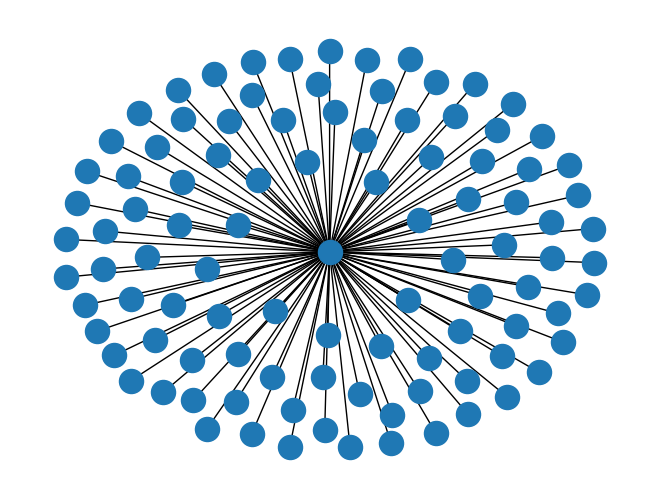

In [3]:
G = nx.Graph()
n = 100

# On ajoute des nodes avec leur valeur que l'on initialise à 0
for i in range(n):
  G.add_node(i, value=0)

# On crée une liste des noeuds
nodes = list(G.nodes)

# On récupère la valeur des noeuds dans une liste
values = nx.get_node_attributes(G, 'value')

# Fonction pour calculer une nouvelle valeur
# Si son degré est égal à 1 alors le noeuf n'a qu'un voisin et on lui attribut cette même valeur
# Si le noeud a plus d'un voisin, on définit sa valeur comme la somme des valeurs de ses voisins
def compute_value(node, values):
  new_value = 0
  if G.degree[node] == 1:
    new_value = 1
  elif G.degree[node] > 1:
    for neighbor in G.neighbors(node):
      new_value += values[neighbor]
  return new_value


# Ordre T aléatoire
rd.shuffle(nodes)

for node in nodes:
  # Dictionnaire des valeurs
  values = dict(sorted(values.items(), key=lambda item: item[1]))
  values.pop(node) # On retire le noeud

  # Valeur maximale qui optimise la valeur du noeud
  max_value = np.asarray(list(values.values())).max()
  
  # On cherche s'il y a égalité
  max_values = [item for item in values.items() if item[1] == max_value]
  
  # Choix du noeud auquel se connecter
  node_to_connect = rd.choice(max_values)
 
  # Connection
  G.add_edge(node, node_to_connect[0])

  # Pour les deux nodes, on recalcule la valeur
  for node2 in [node, node_to_connect[0]]:
    new_value = compute_value(node2, values)
    values[node2] = new_value


  nx.set_node_attributes(G, values, "value")

#print(dict(sorted(values.items(), key=lambda item: item[0])))

nx.draw(G)

Nous observons que pour chaque simulation, il y a toujours un noeud au centre connecté avec tous les autres noeuds. 

Pour réaliser ceci, nous parcourons les noeuds et ajoutons une valeur selon des cas différents. D'abord, leurs valeurs sont initialisées à 0. Puis, elles sont changées à 0 s'il n'y a pas de voisin ; 1 s'il n'y a qu'un voisin. Sinon, la valeur correspondra à la somme des valeurs de ses voisins.

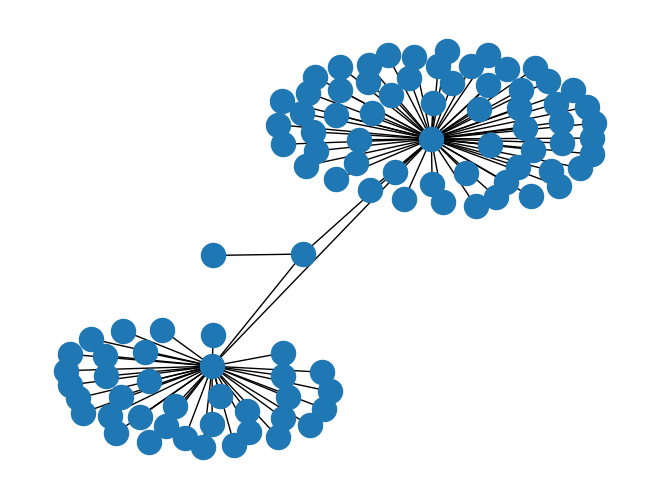

In [6]:
# Partie avec incertitude

G = nx.Graph()
n = 100



# On ajoute des nodes avec leur valeur que l'on initialise à 0
for i in range(n):
  G.add_node(i, value=0, karma = 0)

# On crée une liste des noeuds
nodes = list(G.nodes)

# On récupère la valeur des noeuds dans une liste
values = nx.get_node_attributes(G, 'value')

# Ordre T aléatoire
rd.shuffle(nodes)

values_x = []
values_y = []

for node in nodes:


  # Dictionnaire des valeurs
  values = dict(sorted(values.items(), key=lambda item: item[1]))
  values.pop(node)

  # 
  inferred_values = dict([item[0], rd.uniform(item[1]*0.1, item[1]*10)] for item in values.items())
  
  if node == nodes[len(nodes) - 1]:
    values_x.append(list(inferred_values.keys()))
    values_y.append(list(inferred_values.values()))

  # Valeur max qui optimise la valeur du noeud
  max_value = np.asarray(list(inferred_values.values())).max()

  
  # On cherche s'il y a égalité
  max_values = [item for item in inferred_values.items() if item[1] == max_value]

  # Choix du noeud auquel se connecter
  node_to_connect = rd.choice(max_values)
 
  # Connection
  G.add_edge(node, node_to_connect[0])

  # Pour les deux nodes, on recalcule la valeur
  for node2 in [node, node_to_connect[0]]:
    new_value = compute_value(node2, values)
    values[node2] = new_value

  nx.set_node_attributes(G, values, "value")

#print(dict(sorted(values.items(), key=lambda item: item[0])))
nx.draw(G)

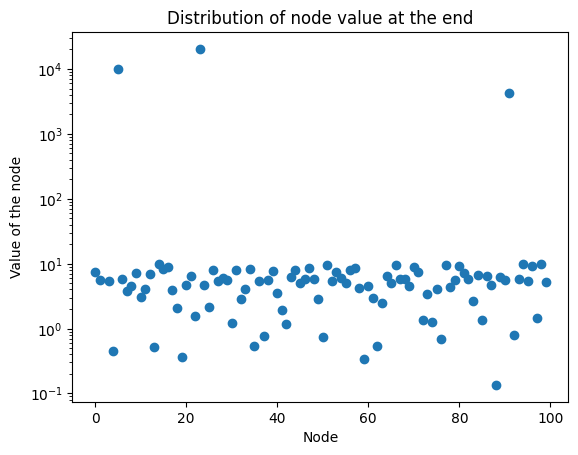

In [7]:
# Affiche la distribution de la valeur des noeuds à la fin de l'itération

plt.scatter(values_x[0], values_y[0])
plt.title("Distribution of node value at the end")
plt.xlabel("Node")
plt.ylabel("Value of the node")
plt.yscale("log")

plt.show()

Nous observons que les valeurs des noeuds sont homogènes exceptés pour 2 valeurs. Celles-ci représentent les 2 plus gros clusters que nous pouvons observer sur le graphique précédent. Cela explique l'importante différence entre ces valeurs.

### Exercice 3 :

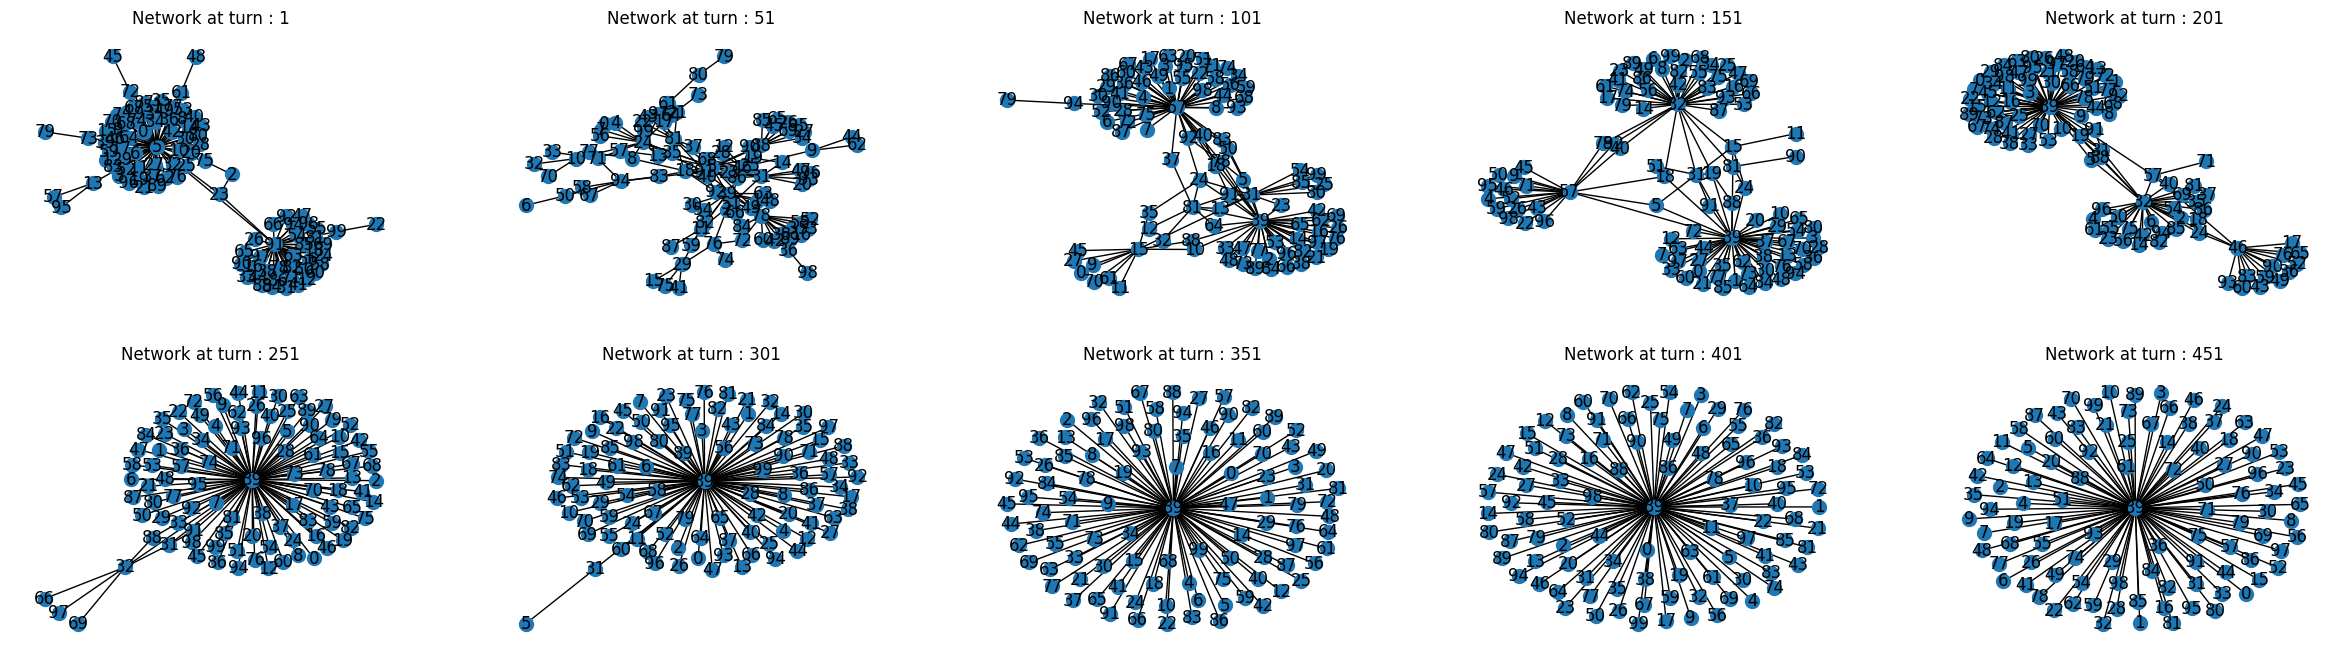

In [8]:
#3.1
graphiques=[]
defectChances = 0.05
turns = 1000
     

karmas = nx.get_node_attributes(G, 'karma')

# Methode de calcul du noeud auquel il vaut mieux se connecter (plus bas Karma, aléatoire si égalité)
def bestToConnect(currentNode): 
    res=[]
    karmasCopy=karmas.copy()
    karmasCopy.pop(currentNode)
    minKarmas = min(karmasCopy.values())
    for key,val in karmas.items():
        # On ajoute les noeuds avec le meilleur karma (Karma le plus faible)
        if val == minKarmas and currentNode != key:
            res.append(key)
    # On retourne l'un des noeuds avec le karma le plus faible au hasard
    return rd.choice(res)



for turn in range(1,turns):
    for node in nodes:
        #karmas = nx.get_node_attributes(G, 'karma')
        if rd.random() <= defectChances: # Cas ou le noeud defect

            # Supression de l'un des lien du noeud
            rdmNeighbor=list(nx.all_neighbors(G,node))[rd.randint(0,len(list(nx.neighbors(G,node)))-1)]
            G.remove_edge(node,rdmNeighbor)

            # Ajutement du karma du noeud (pourcentage)
            karmas[node]=((karmas[node]*(turn-1))+1)/turn

            # Ajout d'un nouveau lien selon le karma
            G.add_edge(node,bestToConnect(node))

            # On vérifie si le noeud auquel il vient de se déconnecter n'est pas sans voisin
            # On le reconnecte en fonction du karma si c'est le cas
            if len(list(nx.all_neighbors(G,rdmNeighbor)))==0:
                G.add_edge(rdmNeighbor,bestToConnect(rdmNeighbor))

        else:
            karmas[node]=(karmas[node]*(turn-1))/turn
    graphiques.append(G.copy())



fig, axs = plt.subplots(2,5,figsize=(30,8))

count = 0
i = 0
while count < 10:
    if count < 5:
        ax = axs[0]
        nx.draw_networkx(graphiques[i], ax=ax[count], node_size=100)
        ax[count].set_title("Network at turn : " + str(i+1))
        ax[count].axis("off")
        count +=1
    else:
        ax = axs[1]
        nx.draw_networkx(graphiques[i], ax=ax[count-5], node_size=100)
        ax[count-5].set_title("Network at turn : " + str(i+1))
        ax[count-5].axis("off")
        count +=1
    i += 50


On modélise ici des intéractions sociales plus avancées entres les individues.

Nous avons fait des choix de conception:

        -Quand un noeud "defect" cela modélisation un arret de la relation entre 2 noeuds uniquement. Cela se traduit par une rupture du liens entre ces noeuds. Le karma du noeud ayant mit fin au lien est diminué.

        -Quand un noeud A coupe une relation avec un noeud B et que B se retrouve seul, B, de la même façon que A, va automatiquement renouer une relation avec un autre noeud selon le karma. La décision est prise par A donc le Karma de A et affecté mais pas celui de B.

Avec l'ajout du Karma on remarque que la modélisation tend vers une forme centré sur un seul point lorsque le nombre de tours est trop élevé, et cela même si plusieurs clusters pouvaient être distingués lors de l'étape précédente.

100%|██████████| 999/999 [00:00<00:00, 9165.68it/s]


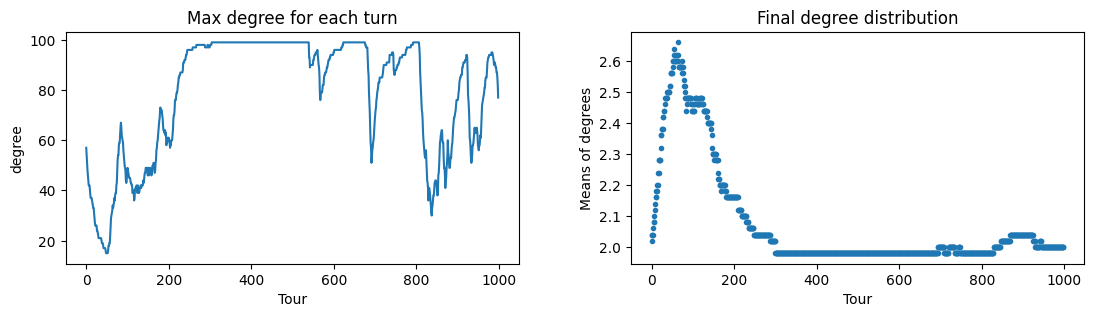

In [9]:
# On initialise nos tableaux
largest_components = []
tab_turns=[]
degrees = []
max_degrees = []
for i in range(len(graphiques)):
    tab_turns.append(i)

# On parcourt tous les graphes afin de récupérer leur degré ainsi que le plus gros cluster et le plus gros degré
for g in tqdm(graphiques):
    largest_components.append(len(max(nx.connected_components(g), key=len))/ n *100)
    degree_sequence = sorted((d for n, d in g.degree()), reverse=True)
    degrees.append(degree_sequence)
    max_degrees.append(degree_sequence[0])

# On créé un plan de 2 figures
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout(pad=5.0)

# Affiche un histogramme des degrés maximum pour chaque tour du graphe
ax1.plot(tab_turns,max_degrees)
ax1.set_title("Max degree for each turn")
ax1.set_xlabel("Tour")
ax1.set_ylabel("degree")

means = []
intervals = []

# On parcourt les dégrés pour calculer l'interval d'erreur pour chaque valeur
for degree in degrees:
    intervals.append(st.t.interval(confidence=0.95,df=len(degree)-1,loc=np.mean(degree),scale=st.sem(degree)))
    means.append(np.mean(degree))


interval_dif_min = []
interval_dif_max = []
# Calcul de l'interval haut/bas
for i in range(len(means)):
    interval_dif_min.append((means[i] - intervals[i][0])*10)
    interval_dif_max.append((intervals[i][1] - means[i])*10)

y_error = [interval_dif_min,interval_dif_max]

# On affiche le nuage de points comprenant leur marge d'erreur
ax2.errorbar(list(range(turn)),means,fmt='o',markersize = 3)
ax2.set_title("Final degree distribution")
ax2.set_xlabel("Tour")
ax2.set_ylabel("Means of degrees")

plt.show()

Le premier graphe est une courbe représentant le plus grand degré pour chaque tour de jeu.

Chaque noeud cherche à avoir le meilleur karma parmis tous les noeuds, c'est pourquoi, nous remarquons alors qu'en debut de jeu, les noeuds se déconnectent les uns des autres avant de se reconnecter par rapport a un noeud central.

Cependant, certains noeuds ont un karma égal au noeud central, c'est pourquoi certains noeuds se déconnectent pour se connecter à l'autre noeud de karma égal, se qui entraine des chutes dans le degré maximum du réseau.

En outre, le second graphe montre la moyenne des degrés du réseau à chaque tour, on voit qu'en debut de jeu, le degré moyen monte rapidement car il y a beaucoup de connexion différentes, par la suite comme les connexions se centre sur un seul noeud, la moyenne des degré diminue

### Exercice 4 :